# Visualization API Example

This notebook shows how how to use the `visualization` library for viewing images stored on disk.

In [1]:
import sys
if '../' not in sys.path:
    sys.path.append("../")

import matplotlib.pyplot as plt
    
import storage
import visualization; reload(visualization)

%matplotlib inline

In [2]:
# Open an on-disk image dataset.
dataset = storage.DiskDataset("/tmp/ipis")

# pd.DataFrame listing all (location_id, image_source_id, metadata).
dataset.metadata().sort_values(["location_id", "source_id"]).sample(5)

,location_id,metadata,source_id
173,codmine00403,"{u'projection': u'WGS 84', u'bottom_right': [2...",mask
91,codmine00049,"{u'projection': u'WGS 84', u'bottom_right': [2...",mask
312,codmine00086,"{u'dates': [u'20161015', u'20161116', u'201612...",landsat8
378,codmine01771,"{u'dates': [u'20161015', u'20161116', u'201612...",landsat8
106,codmine00101,"{u'dates': [u'20161015', u'20161116', u'201612...",landsat8


In [3]:
# Loads image from disk.
location_id = "codmine00126"
image = dataset.load_image(location_id, "landsat8")
mask = dataset.load_image(location_id, "mask")
meta = dataset.image_metadata(location_id, "landsat8")["metadata"]
date = 2


longitude, latitude = meta["center"]
print("longitude = %f | latitude = %f" % (longitude, latitude))
visualization.create_google_maps_link(longitude, latitude)

longitude = 30.035037 | latitude = 2.021614


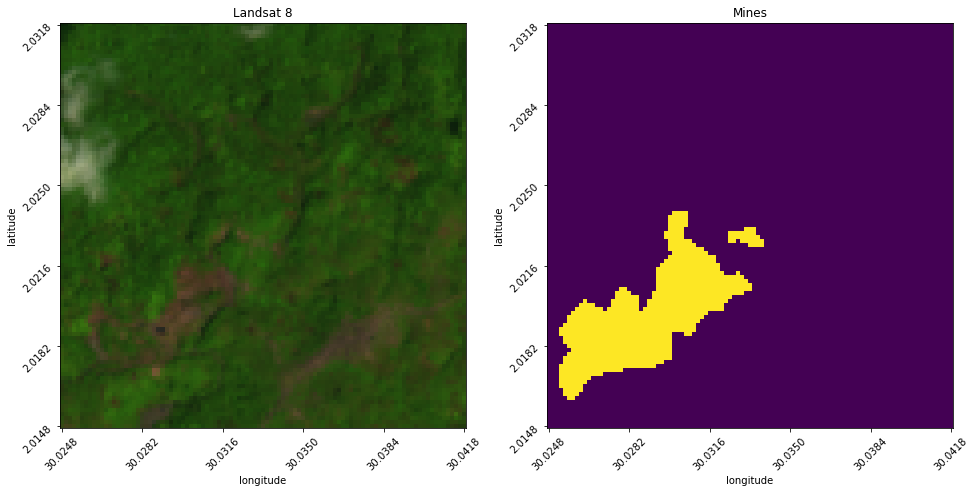

In [4]:
# Visualize image

fig, axs = plt.subplots(1, 2, figsize=(16, 16))

plt.sca(axs[0])
visualization.show_image(
    image[:, :, [5, 4, 3], date], 
    visualization.BoundingBox.from_metadata(meta), 
    title="Landsat 8")

plt.sca(axs[1])
visualization.show_image(
    mask,
    visualization.BoundingBox.from_metadata(meta), 
    title="Mines")

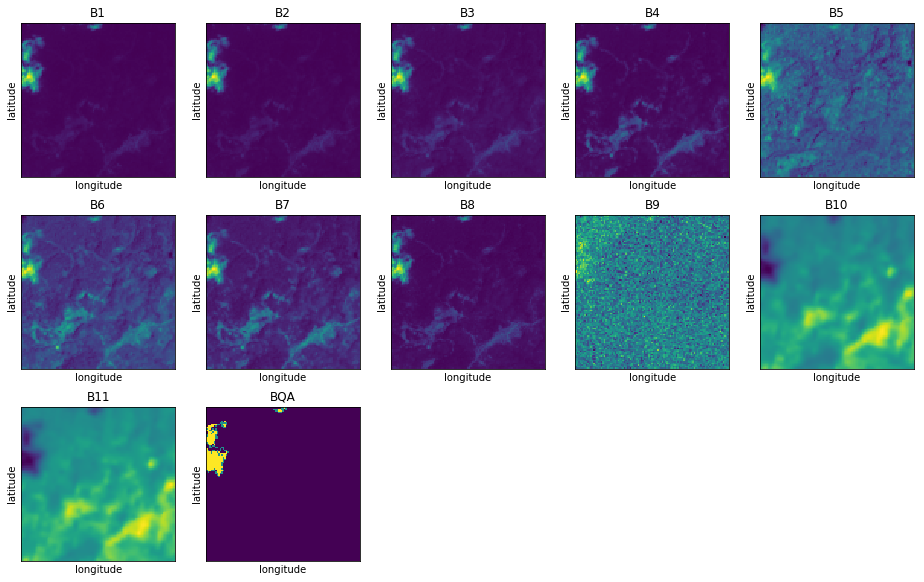

In [5]:
# Visualize color bands.
    
plt.figure(figsize=(16, 10))
visualization.show_color_bands(
    image[..., date], 
    ncols=5, 
    titles=meta['bands'])

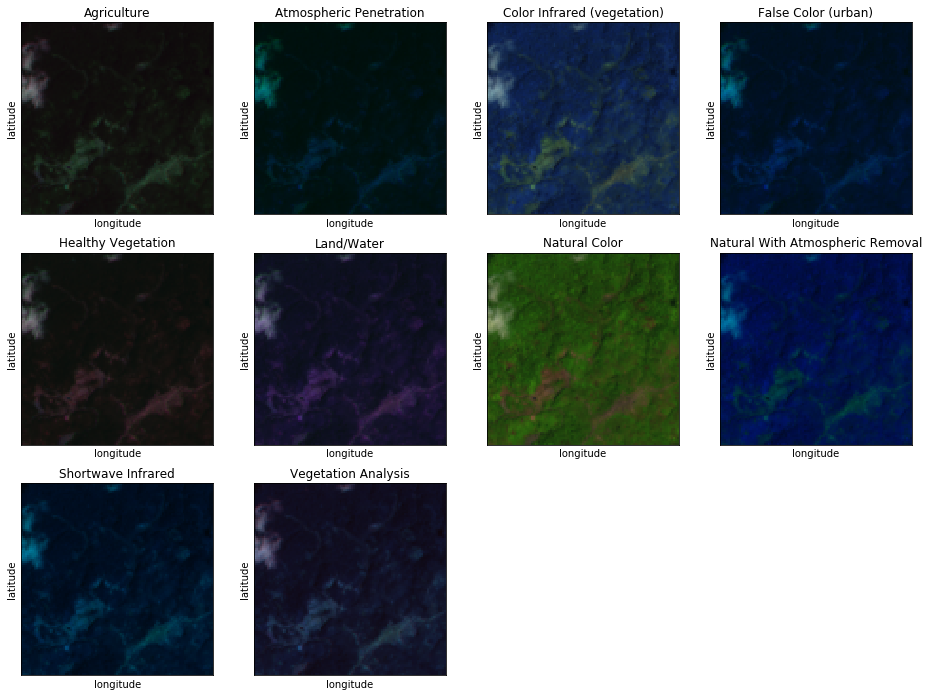

In [6]:
# View recommended color combinations for Landsat 8 imagery.
    
plt.figure(figsize=(16, 12))
visualization.show_landsat8_color_combinations(image[..., date], ncols=4)

In [7]:
# Build map. Overlay image on top.

folium_map = visualization.create_folium_map(
    visualization.BoundingBox.from_metadata(meta), 
    tiles='ArcGIS')
visualization.overlay_image_on_map(
    folium_map, 
    image[:, :, [5, 4, 3], date], 
    visualization.BoundingBox.from_metadata(meta), 
    opacity=0.75)
visualization.overlay_image_on_map(
    folium_map, 
    mask, 
    visualization.BoundingBox.from_metadata(meta), 
    opacity=0.2)

folium_map